In [23]:
import csv
import mne
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import pickle
from pathlib import Path

In [24]:
%matplotlib inline

In [25]:
ELECTRODE_NAMES = [
    'C2', 'Cz', 'C1', 'C3', 'CP2', 'CPz', 'CP1', 'CP3',
    'TP9', 'O1', 'P7', 'C5', 'Fp1', 'F7', 'FC3', 'T7',
    'CP6', 'C4', 'C6', 'T8', 'F8', 'Fp2', 'FC6', 'AFz',
    'FC1', 'FCz', 'FC4', 'FC2', 'CP4', 'TP10', 'O2', 'P8',
]

In [37]:
file_path = "../data/20250512/ishii0008.vhdr"

In [38]:
# .vhdrファイルを指定してEEGデータを読み込む
raw = mne.io.read_raw_brainvision(file_path, preload=True)
rename_mapping = {ch: ELECTRODE_NAMES[i] for i, ch in enumerate(raw.ch_names)}
raw.rename_channels(rename_mapping)
raw.set_montage('easycap-M1')

Extracting parameters from ../data/20250512/ishii0008.vhdr...
Setting channel info structure...
Reading 0 ... 88049  =      0.000 ...   176.098 secs...


<RawBrainVision | ishii0008.eeg, 31 x 88050 (176.1 s), ~20.9 MiB, data loaded>

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    0.1s finished
/home/neuron/Documents/mi-analyze/.venv/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


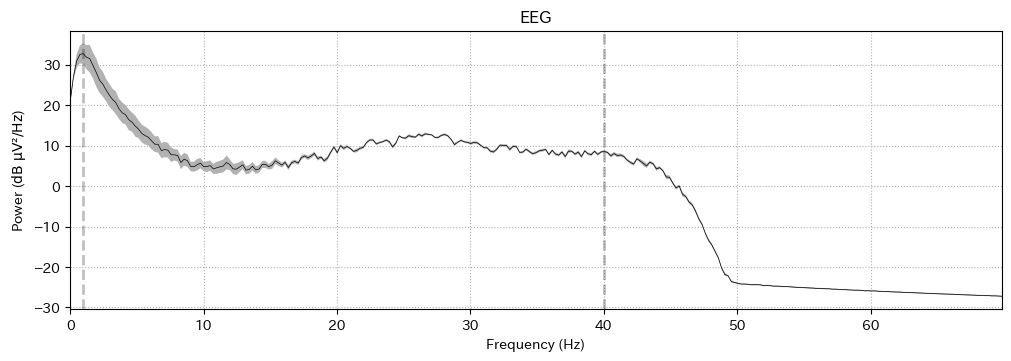

In [39]:
raw.filter(l_freq=1, h_freq=40)
fig = raw.compute_psd(tmax=np.inf, fmax=70).plot(
    average=True, amplitude=False, picks="data", exclude="bads"
)

ICAによるノイズ除去を開始します...
Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.6s.


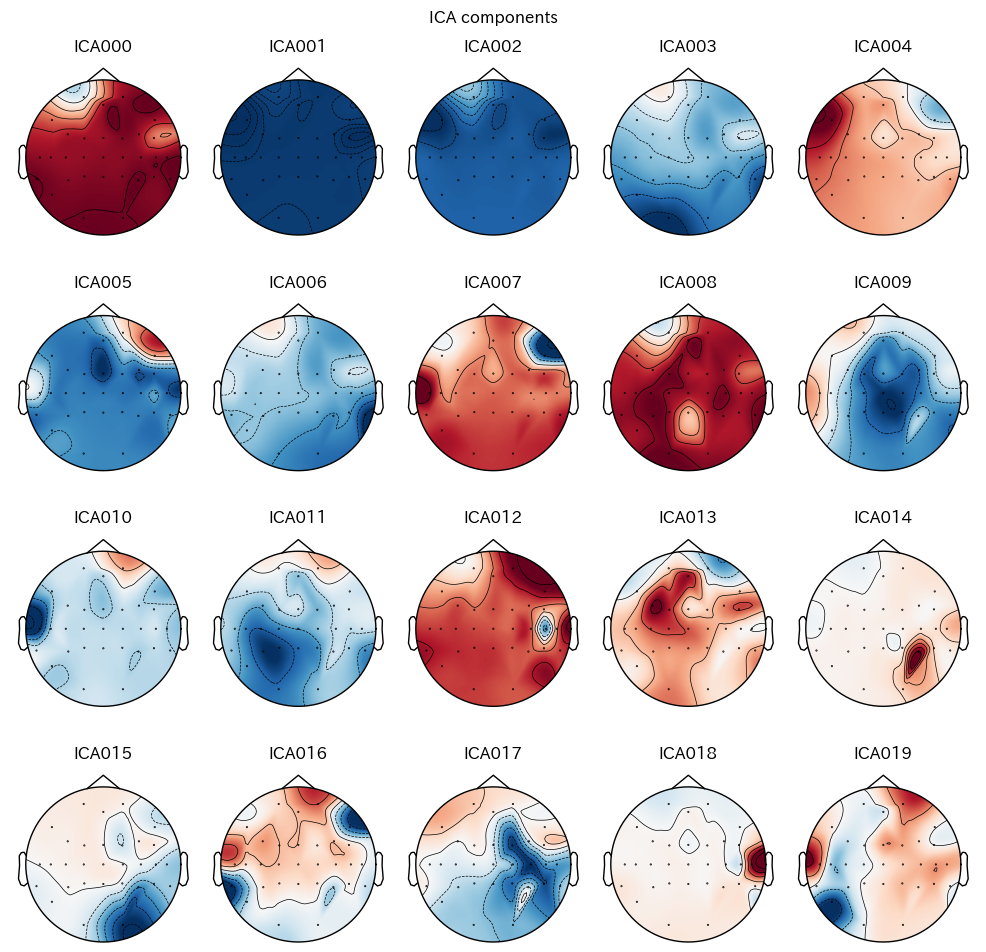

In [40]:
# ICAによるノイズ除去
print("ICAによるノイズ除去を開始します...")
ica = mne.preprocessing.ICA(n_components=20, random_state=42)
ica.fit(raw)
fig = ica.plot_components()

Creating RawArray with float64 data, n_channels=20, n_times=88050
    Range : 0 ... 88049 =      0.000 ...   176.098 secs
Ready.


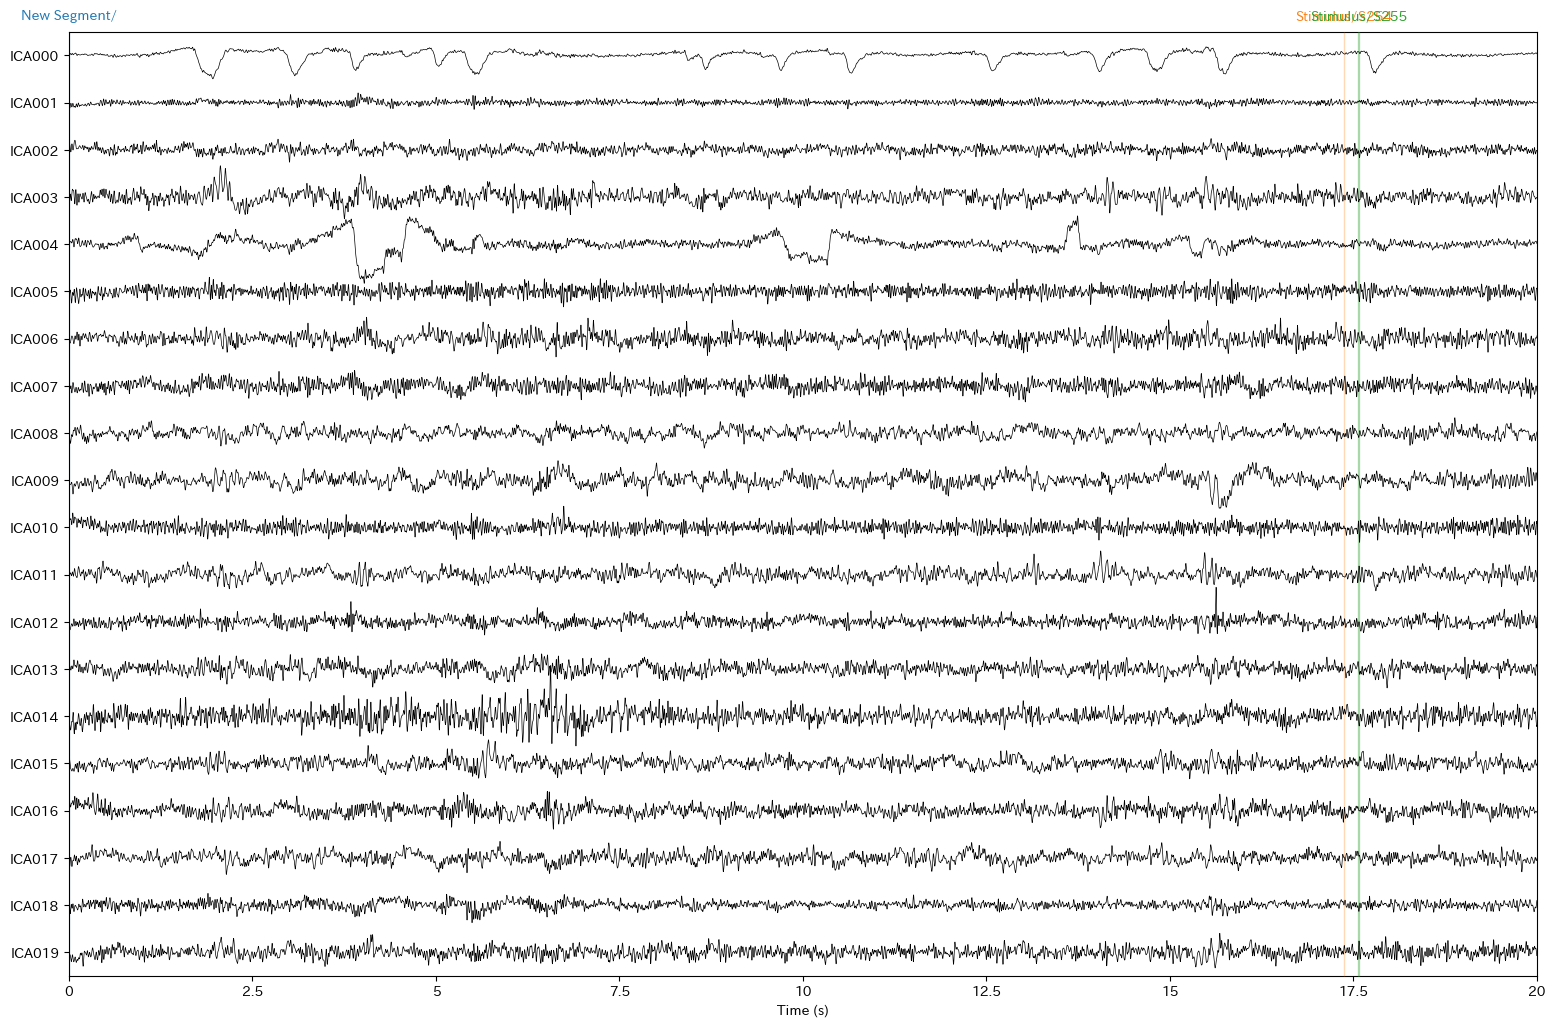

In [41]:
fig = ica.plot_sources(raw, show_scrollbars=False)

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated


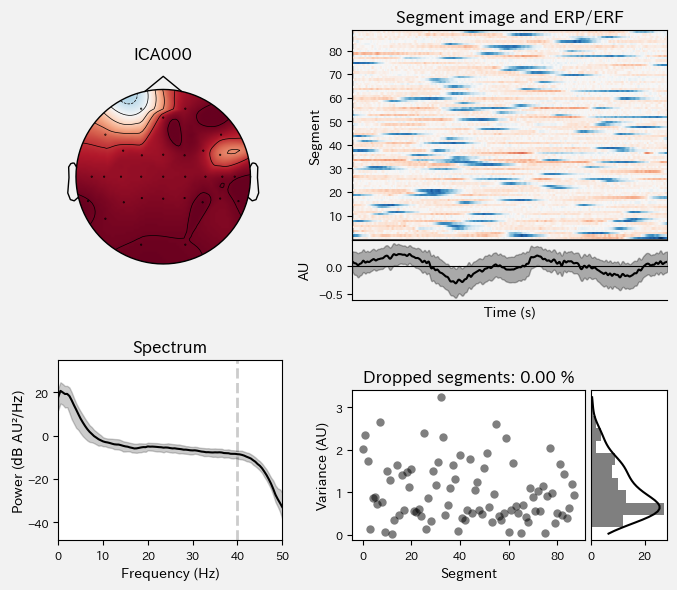

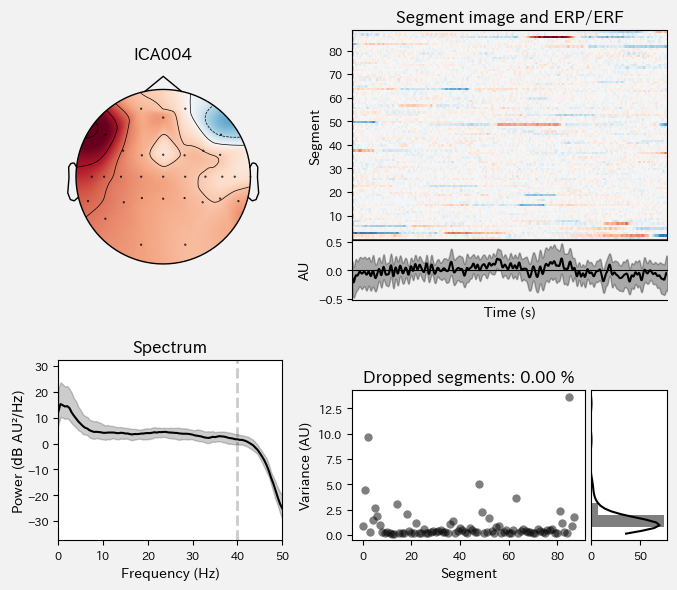

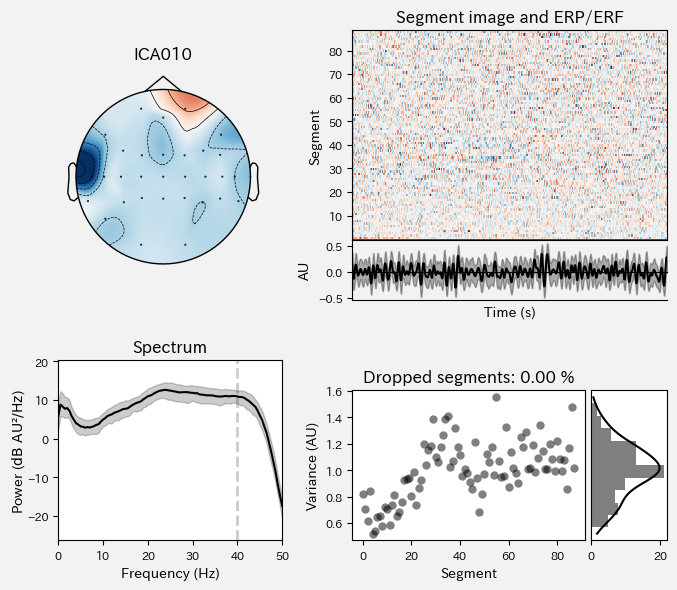

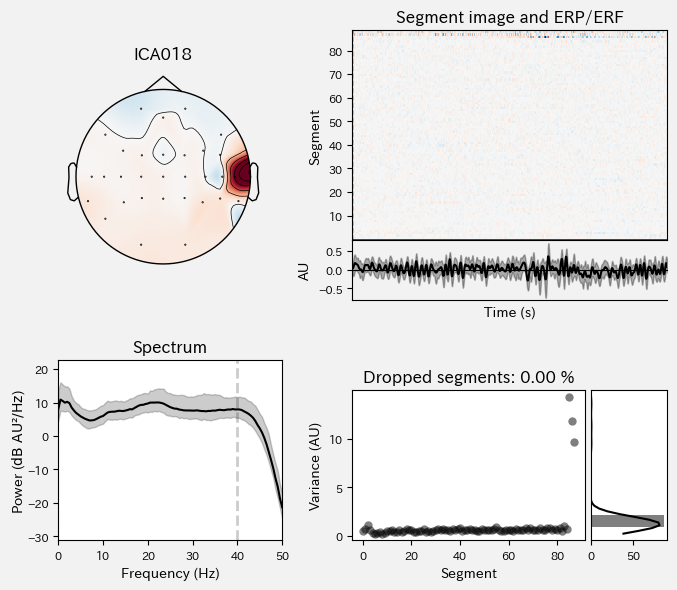

In [45]:
# 取り除くコンポーネントを選択
ica.exclude = [0, 4, 10, 18]
figs = ica.plot_properties(raw, picks=ica.exclude, psd_args={'fmax': 50}, show=True)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 4 ICA components
    Projecting back using 31 PCA components


/home/neuron/Documents/mi-analyze/.venv/lib/python3.12/site-packages/mne/viz/_mpl_figure.py:2150: UserWarning: Glyph 181 (\N{MICRO SIGN}) missing from font(s) IPAexGothic.
  self.canvas.draw_idle()
/home/neuron/Documents/mi-analyze/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 181 (\N{MICRO SIGN}) missing from font(s) IPAexGothic.
  fig.canvas.print_figure(bytes_io, **kw)


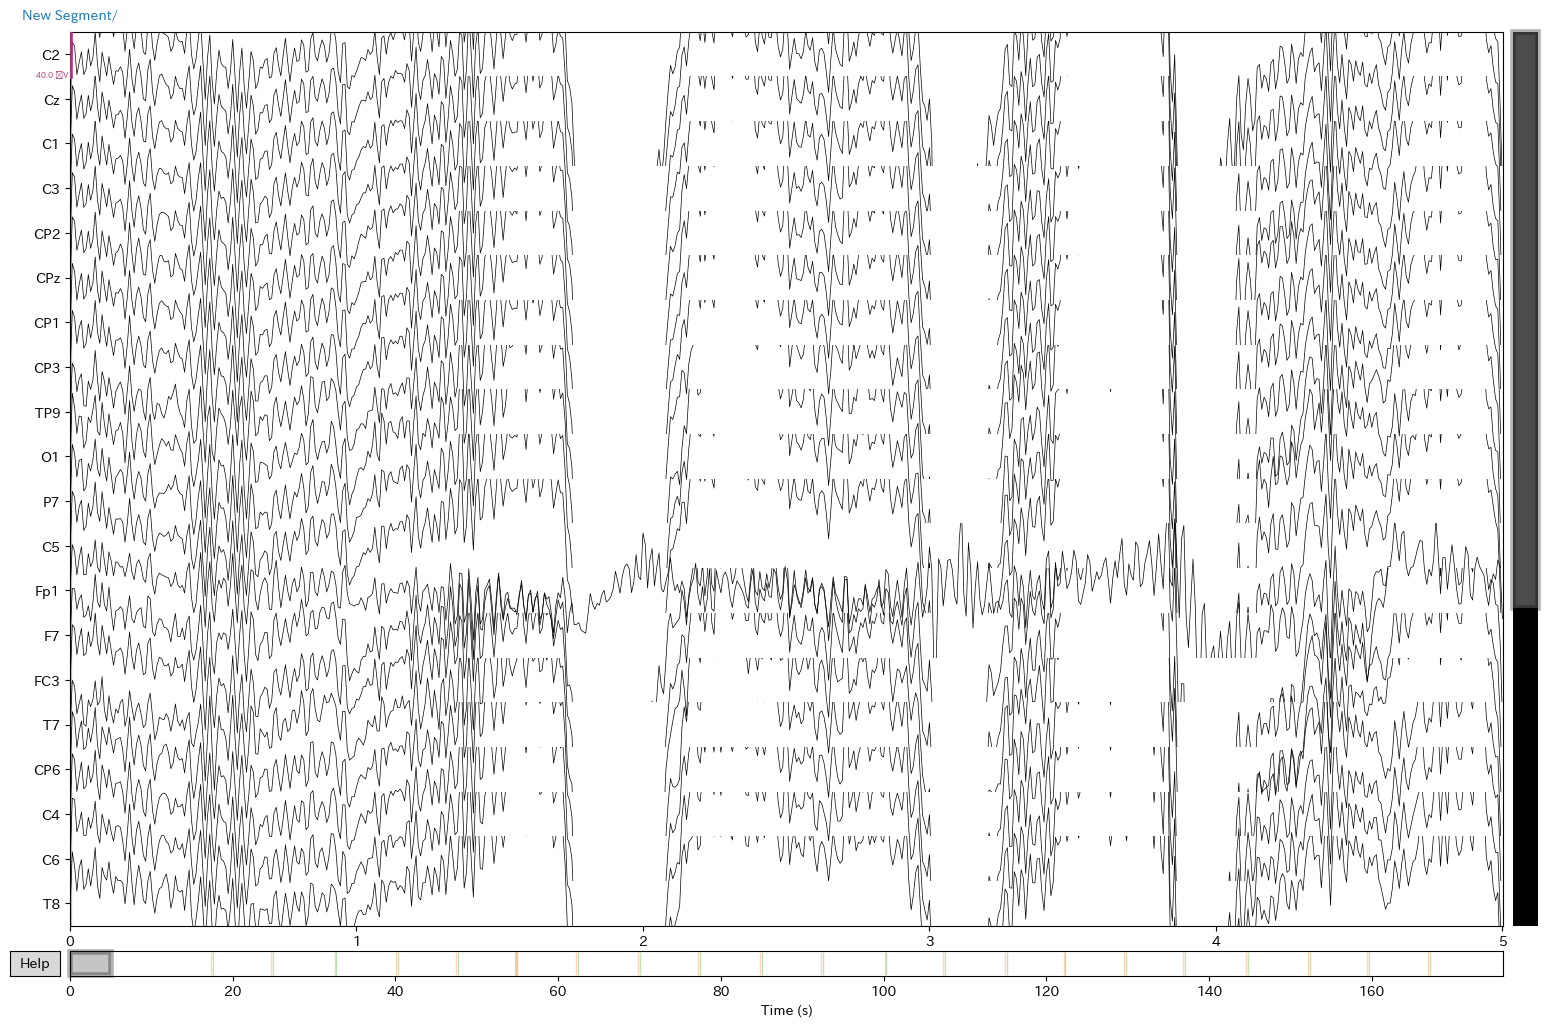

/home/neuron/Documents/mi-analyze/.venv/lib/python3.12/site-packages/mne/viz/_mpl_figure.py:2150: UserWarning: Glyph 181 (\N{MICRO SIGN}) missing from font(s) IPAexGothic.
  self.canvas.draw_idle()
/home/neuron/Documents/mi-analyze/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 181 (\N{MICRO SIGN}) missing from font(s) IPAexGothic.
  fig.canvas.print_figure(bytes_io, **kw)


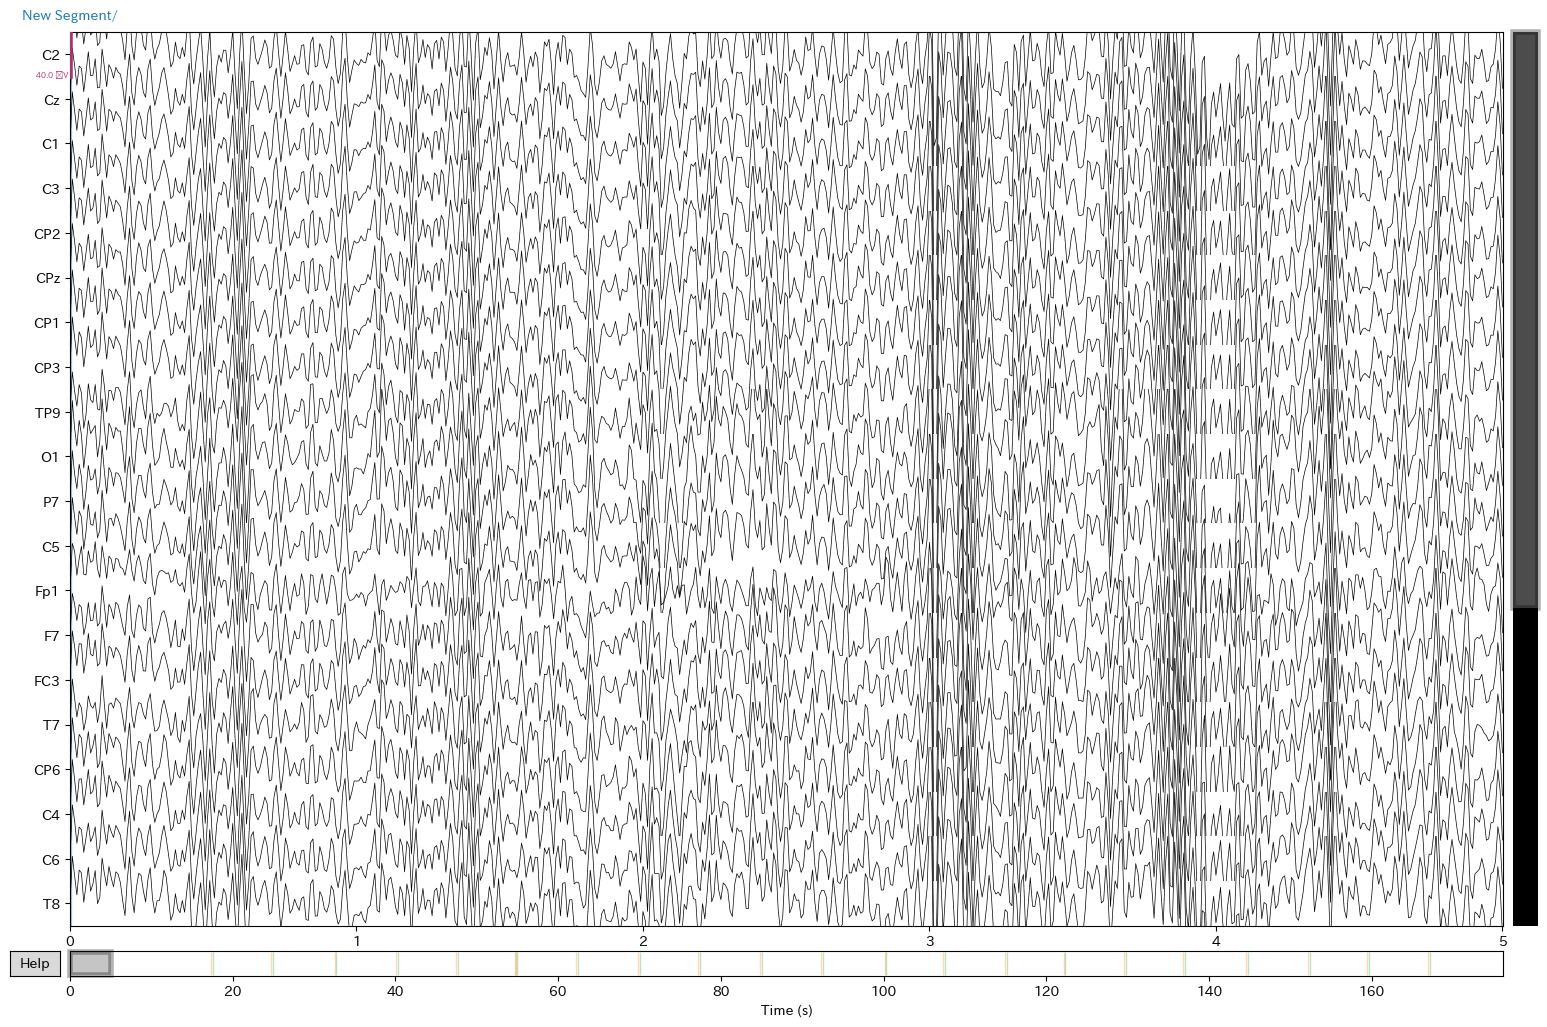

In [46]:
# ノイズ除去を適用
raw_cleaned = raw.copy()
ica.apply(raw_cleaned)

# 元のデータと比較
raw.plot(duration=5, title='Original Data')
raw_cleaned.plot(duration=5, title='ICA Cleaned Data')
None

In [47]:
# ここまでのデータをpickleで保存
file_name = Path(file_path).stem
processed_dir = Path(file_path).parent / 'processed'
processed_dir.mkdir(parents=True, exist_ok=True)
# raw_cleanedをpickleで保存
pickle_file_path = processed_dir / f"{file_name}_ica.pkl"
with open(pickle_file_path, 'wb') as f:
    pickle.dump(raw_cleaned, f)
pickle_file_path

PosixPath('../data/20250512/processed/ishii0008_ica.pkl')